<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
Predicting Loan Repayment</h1><br>

<p align="center">
<img src="images/Loans-borrow-repay.jpg"; style="height: 400px; width: 800px">
</p>

 <h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Introduction</h2><br>
**Ensemble methods** can be defined as combining several different models (base learners) into final model (meta learner) to reduce the generalization error. It relies on the assumption that each model would look at a different aspect of the data which yield to capturing part of the truth. Combining good performing models the were trained independently will capture more of the truth than a single model. Therefore, this would result in more accurate predictions and lower generalization errors.
- Almost always ensemble model performance gets improved as we add more models.
- Try to combine models that are as much different as possible. This will reduce the correlation between the models that will improve the performance of the ensemble model that will lead to significantly outperform the best model. In the worst case where all models are perfectly correlated, the ensemble would have the same performance as the best model and sometimes even lower if some models are very bad. As aresult, pick models that are as good as possible.

Diﬀerent ensemble methods construct the ensemble of models in diﬀerent ways. Below are the most common methods:
- Averaging the predictions of all models.
- Bagging: build different models on different datasets and then take the majority vote from all the models. Given the original dataset, we sample with replacement to get the same size of the original dataset. Therefore, each dataset will include, on average, 2/3 of the original data and the rest 1/3 will be duplicates. Since each model will be built on different dataset, it can be seen as a different model.
- Boosting: build models sequentially. That means each model learns from the residuals for the previous model. The output will be all output of each single model weighted by the learning rate ($\lambda$).
- Build k models called base learners. Then fit a model to the output of the base learners to predict the final output. We'll explain more in "Modeling" section of how it works.

 <h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Dataset</h2><br>
The two most critical questions in the lending industry are: 1) How risky is the borrower? 2) Given the borrower's risk, should we lend him? The answer to the first question determines the interest rate the borrower would have. Interest rate measures among other things (such as time value of money) the riskness of the borrower. The riskier the borrower, the higher the interest rate. With interest rate in mind, we can then determine if the borrower is eligible for the loan.

Investors(lenders) provide loans to borrowers in exchange for the promise of repayment with interest. That means the lender only makes profit (interest) if the borrower pays off the loan. However, if he doesn't repay the loan, then the lender loses money.

We'll be using publicly available data from [LendingClub.com](https://www.LendingClub.com). The data covers the 9,578 loans funded by the platform between May 2007 and February 2010. The interest rate is provided to us for each borrower. Therefore, so we'll address the second question indirectly by trying to predict if the borrower will repay the loan by its mature date or not.

Below is a short description of each feature in the data set:
- credit_policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
- purpose: The purpose of the loan such as: credit_card, debt_consolidation, etc.
- int_rate: The interest rate of the loan (proportion).
- installment: The monthly installments (\$) owed by the borrower if the loan is funded.
- log_annual_inc: The natural log of the annual income of the borrower.
- dti: The debt-to-income ratio of the borrower.
- fico: The FICO credit score of the borrower.
- days_with_cr_line: The number of days the borrower has had a credit line.
- revol_bal: The borrower's revolving balance.
- revol_util: The borrower's revolving line utilization rate.
- inq_last_6mths: The borrower's number of inquiries by creditors in the last 6 months.
- delinq_2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
- pub_rec: The borrower's number of derogatory public records.
- not_fully_paid: indicates whether the loan was not paid back in full (the borrower either defaulted or the borrower was deemed unlikely to pay it back).

Let's load the data, take a look at the data types of each feature and check if we have missing values.

In [42]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import fan
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import Imputer, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
import xgboost as xgb

# os.chdir("../")
# from scripts.plot_roc import plot_conf_matrix_and_roc, plot_roc

%matplotlib inline
plt.style.use("ggplot")
sns.set_context("notebook")

In [50]:
# Load the data
df = pd.read_csv("../data/loans.csv")

# Check both the datatypes and if there is missing values
print(f"\033[1m\033[94mData types:\n{11 * '-'}")
print(f"\033[30m{df.dtypes}\n")
print(f"\033[1m\033[94mSum of null values in each column:\n{35 * '-'}")
print(f"\033[30m{df.isnull().sum()}")
df.head()

Data types:
-----------
credit_policy          int64
purpose               object
int_rate             float64
installment          float64
log_annual_inc       float64
dti                  float64
fico                   int64
days_with_cr_line    float64
revol_bal              int64
revol_util           float64
inq_last_6mths       float64
delinq_2yrs          float64
pub_rec              float64
not_fully_paid         int64
dtype: object

Sum of null values in each column:
-----------------------------------
credit_policy         0
purpose               0
int_rate              0
installment           0
log_annual_inc        4
dti                   0
fico                  0
days_with_cr_line    29
revol_bal             0
revol_util           62
inq_last_6mths       29
delinq_2yrs          29
pub_rec              29
not_fully_paid        0
dtype: int64


,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0.0,0.0,0.0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0.0,0.0,0.0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1.0,0.0,0.0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1.0,0.0,0.0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0.0,1.0,0.0,0


It looks like we have missing data in almost half of the features. Let's check the count of each class to see if we are dealing with balanced/imbalanced classification problem.

Positive examples = 1533
Negative examples = 8045
Proportion of positive to negative examples = 19.06%


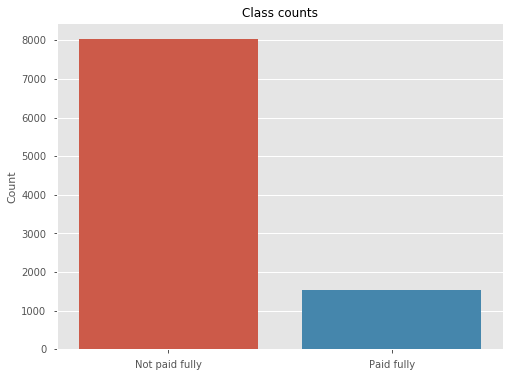

In [51]:
# Get number of positve and negative examples
pos = df[df["not_fully_paid"] == 1].shape[0]
neg = df[df["not_fully_paid"] == 0].shape[0]
print(f"Positive examples = {pos}")
print(f"Negative examples = {neg}")
print(f"Proportion of positive to negative examples = {(pos / neg) * 100:.2f}%")
plt.figure(figsize=(8, 6))
sns.countplot(df["not_fully_paid"])
plt.xticks((0, 1), ["Not paid fully", "Paid fully"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts");

Since we are dealing with imbalanced data, we'll explain in more details in "Data Preprocessing" section on how to deal with it. Note that positive example here means that the borrower didn't fully pay the loan, not the other way around.

<h3 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Data Preprocessing</h3>

1. Create dummy variables from the feature "purpose" since its nominal (not ordinal) categorical variable. It's also a good practice to drop the first one to avoid linear dependency between the resulted features since some algorithms may struggle with this issue.
2. Split the data into train and test using 80/20 split rule.
3. Impute the missing values using the mean of each feature.
4. Standardize the data so that each feature would have zero mean and 1 standard deviation.
5. Since we're dealing with imbalanced data, class imbalance influences a learning algorithm during training by making the decision rule biased towards the majority class by implicitly learns a model that optimizes the predictions based on the majority class in the dataset. To deal with this issue, we'll upsample the positive examples to be equal the negative examples and use metrics other than accuracy when comparing models such as *f1-score* or *AUC* (area under ROC curve).

Note that **Imputation** and **Standardization** should be first fit to training data and then transform test data. 

In [74]:
# Create dummy variables from the feature purpose
df = pd.read_csv("../data/loans.csv")
df = pd.get_dummies(df, columns=["purpose"], drop_first=True)
# Create binary features to for each feature to check if each example is nan
df["is_log_annual_inc_missing"] = np.isnan(df.log_annual_inc) * 1
print(np.sum(df.is_log_annual_inc_missing))
df["is_days_with_cr_line_missing"] = np.isnan(df.days_with_cr_line) * 1
print(np.sum(df.is_days_with_cr_line_missing))
df["is_revol_util_missing"] = np.isnan(df.revol_util) * 1
print(np.sum(df.is_revol_util_missing))
df["is_inq_last_6mths_missing"] = np.isnan(df.inq_last_6mths) * 1
print(np.sum(df.is_inq_last_6mths_missing))
df["is_delinq_2yrs_missing"] = np.isnan(df.delinq_2yrs) * 1
print(np.sum(df.is_delinq_2yrs_missing))
df["is_pub_rec_missing"] = np.isnan(df.pub_rec) * 1
print(np.sum(df.is_pub_rec_missing))
# df.head()

4
29
62
29
29
29


In [57]:
df.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0.0,0.0,0.0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0.0,0.0,0.0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1.0,0.0,0.0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1.0,0.0,0.0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0.0,1.0,0.0,0,1,0,0,0,0,0


In [60]:
np.dtype(df.iloc[7726, 3])

dtype('float64')

In [67]:
np.isnan(df.iloc[7726, 3])

True

In [65]:
df.iloc[7726, 3] == np.NAN

False

In [49]:
np.unique(df["log_annual_inc"])

array([7.54750168, 7.60090246, 8.10167775, ...,        nan,        nan,
              nan])

In [44]:
np.sum(df["is_log_annual_inc_missing"])

0

In [4]:
# Convert dataframe into features and labels nd-arrays
X = df.loc[:, df.columns != "not_fully_paid"].values
y = df.loc[:, df.columns == "not_fully_paid"].values.flatten()

# Split the data into train and test using 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7662, 13), (7662,), (1916, 13), (1916,))

In [14]:
for feature in df.columns:
    print(f"{feature}:\n{df[feature].value_counts()}")

credit_policy:
1    7710
0    1868
Name: credit_policy, dtype: int64
purpose:
debt_consolidation    3957
all_other             2331
credit_card           1262
home_improvement       629
small_business         619
major_purchase         437
educational            343
Name: purpose, dtype: int64
int_rate:
0.1253    354
0.0894    299
0.1183    243
0.1218    215
0.0963    210
0.1114    206
0.0800    198
0.1287    197
0.1148    193
0.0932    187
0.0859    187
0.1221    182
0.1189    165
0.1322    159
0.0774    154
0.1284    152
0.1357    152
0.1347    146
0.1392    142
0.1316    141
0.1496    138
0.1426    138
0.1600    126
0.1379    125
0.1461    113
0.1531    113
0.1411    113
0.1158    107
0.1442    106
0.1126     95
         ... 
0.1462      4
0.1659      4
0.1457      3
0.1904      3
0.1467      3
0.1886      3
0.1646      3
0.1349      3
0.1793      3
0.2090      2
0.2164      2
0.1728      2
0.1854      2
0.1709      2
0.1830      2
0.1759      2
0.1633      2
0.1791      2
0.1936   

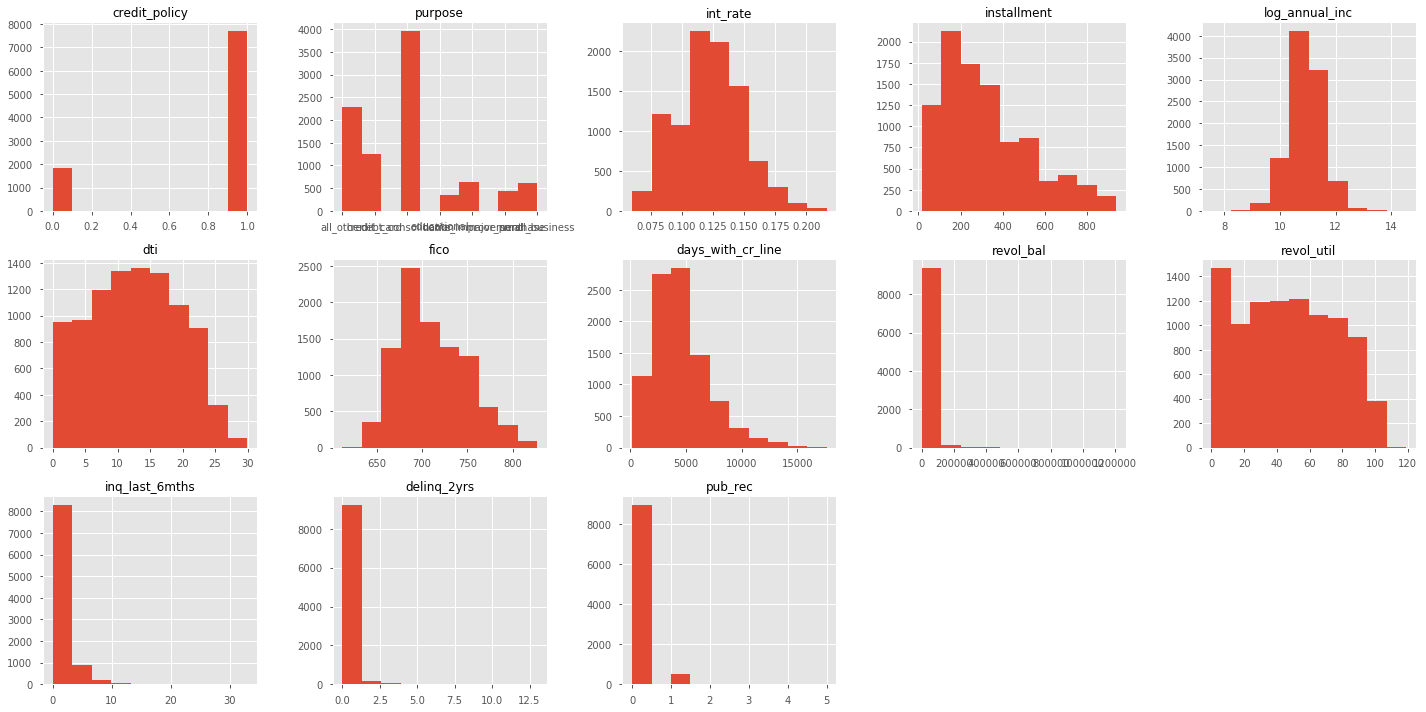

In [40]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
for i, ax in enumerate(axes.ravel()):
    if i > 12:
        ax.set_visible(False)
        continue
    ax.hist(df.dropna()[df.columns[i]])
    ax.set_title(df.columns[i])
plt.tight_layout()

In [6]:
# Impute the missing data using features means
imp = Imputer()
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)
print(
    f"\033[1m\033[94mSum of null values in training data: {np.isnan(X_train).sum()}")
print(f"Sum of null values in test data: {np.isnan(X_test).sum()}")

Sum of null values in training data: 0
Sum of null values in test data: 0


In [7]:
# Standardize the data
std = RobustScaler()
std.fit(X_train)
X_train = std.transform(X_train) 
X_test = std.transform(X_test)

In [8]:
# Upsample minority class
X_train_u, y_train_u = resample(X_train[y_train == 1],
                                y_train[y_train == 1],
                                replace=True,
                                n_samples=X_train[y_train == 0].shape[0],
                                random_state=1)
X_train_u = np.concatenate((X_train[y_train == 0], X_train_u))
y_train_u = np.concatenate((y_train[y_train == 0], y_train_u))
print("Original shape:", X_train.shape, y_train.shape)
print("Upsampled shape:", X_train_u.shape, y_train_u.shape)

Original shape: (7662, 18) (7662,)
Upsampled shape: (12872, 18) (12872,)


In [9]:
# Down sample majority class
X_train_d, y_train_d = resample(X_train[y_train == 0],
                                y_train[y_train == 0],
                                replace=True,
                                n_samples=X_train[y_train == 1].shape[0],
                                random_state=1)
X_train_d = np.concatenate((X_train[y_train == 1], X_train_d))
y_train_d = np.concatenate((y_train[y_train == 1], y_train_d))
print("Original shape:", X_train.shape, y_train.shape)
print("Downsampled shape:", X_train_d.shape, y_train_d.shape)

Original shape: (7662, 18) (7662,)
Downsampled shape: (2452, 18) (2452,)


Now the dataset is ready for modeling. Also, the upsampled training data size is 12,872; however, the test data size is 1,916 which was not affected by the upsampling step.

<h3 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Modeling</h3>

In [11]:
pip_rf = make_pipeline(RandomForestClassifier(class_weight="balanced",
                                              random_state=123))
hyperparam_grid = {
        "randomforestclassifier__n_estimators": [10, 50, 100, 500],
        "randomforestclassifier__max_features": ["sqrt", "log2", 0.4, 0.5],
        "randomforestclassifier__min_samples_leaf": [1, 3, 5],
        "randomforestclassifier__criterion": ["gini", "entropy"]}
    
gs_rf = GridSearchCV(pip_rf,
                     hyperparam_grid,
                     scoring="f1",
                     cv=10,
                     n_jobs=-1)
gs_rf.fit(X_train_u, y_train_u)
print(f"{gs_rf.best_score_ * 100:.2f}")

98.47


In [13]:
roc_auc_score(y_test, gs_rf.best_estimator_.predict_proba(X_test)[:, 1])

0.6817423572210874

In [16]:
pip_logmod = make_pipeline(LogisticRegression(class_weight="balanced"))

hyperparam_range = np.arange(0.5, 20.1, 0.5)

hyperparam_grid = {"logisticregression__penalty": ["l1", "l2"],
                   "logisticregression__C":  hyperparam_range,
                   "logisticregression__fit_intercept": [True, False]
                   }

gs_logmodel = GridSearchCV(pip_logmod,
                           hyperparam_grid,
                           scoring="f1",
                           cv=10,
                           n_jobs=-1)

gs_logmodel.fit(X_train_u, y_train_u)
print(f"{gs_logmodel.best_score_ * 100:.2f}")

63.74


In [17]:
roc_auc_score(y_test, gs_logmodel.best_estimator_.predict_proba(X_test)[:, 1])

0.7061217135696398

In [21]:
pip_xgb = make_pipeline(xgb.XGBClassifier())

hyperparam_grid = {
    "xgbclassifier__n_estimators": [10, 50, 100, 500],
    "xgbclassifier__learning_rate": [0.01, 0.1, 0.5, 1.0, 10.0, 50.0, 100.0],
    "xgbclassifier__gamma": np.arange(0., 0.51, 0.05),
    "xgbclassifier__max_depth": [1, 2, 3, 4, 5, 10, 20, 50],
    "xgbclassifier__subsample": np.arange(0.0, 1.01, 0.1)
}

gs_xgb = GridSearchCV(pip_xgb,
                      hyperparam_grid,
                      scoring="f1",
                      cv=2,
                      n_jobs=-1,
                      verbose=1)

gs_xgb.fit(X_train_u, y_train_u)
print(f"{gs_xgb.best_score_ * 100:.2f}")

Fitting 2 folds for each of 27104 candidates, totalling 54208 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.3s


KeyboardInterrupt: 

In [29]:
# Build and train ensemble model
def train_ensemble(X_train, y_train, X_test):
    # Split the training data into training and validation where training
    # will be used in fitting base learners and validation will be used to
    # fit meta learner model,=.
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                          test_size=0.5,
                                                          random_state=123,
                                                          stratify=y)

    # Build base learners
    def build_base_learners():
        base_learners = {"random_forest": RandomForestClassifier(n_estimators=500,
                                                                 max_features=0.25,
                                                                 criterion="entropy"),
                         "logistic_regression": LogisticRegression(C=1.5,
                                                                   penalty="l1",
                                                                   fit_intercept=True),
                         "extra_tree": ExtraTreesClassifier(n_estimators=1000,
                                                            max_features="log2",
                                                            criterion="entropy"),
                         "gradient_boosting": GradientBoostingClassifier(loss="deviance",
                                                                         learning_rate=0.1,
                                                                         n_estimators=500,
                                                                         max_depth=3,
                                                                         max_features="log2"),
                         "svc": SVC(C=0.01, gamma=0.1, kernel="poly", degree=3, coef0=10,
                                    probability=True)}
        return base_learners


    # Build meta learner
    def build_meta_learner():
        meta_learner = RandomForestClassifier(n_estimators=500,
                                              max_features=0.25,
                                              criterion="entropy")
        return meta_learner


    # Train base learners
    def train_base_learners(base_learners_dict, X_train, y_train):
        for name, classifier in base_learners.items():
            print(f"\033[1m\033[94mTraining {name} classifier...")
            classifier.fit(X_train, y_train)
            print(f"\033[1m\033[92mDone")
        

    # Predict the prob matrix for positive examples for all base learners
    def base_learners_predict(base_learners, X_valid):
        base_learners_names = base_learners.keys()
        prob_matrix = np.zeros((X_valid.shape[0], len(base_learners)))
        prob_matrix = pd.DataFrame(prob_matrix)
        prob_matrix.columns = base_learners_names

        for name, classifier in base_learners.items():
            prob_matrix.loc[:, name] = classifier.predict_proba(X_valid)[:, 1]

        return prob_matrix


    # Train meta learner using the probability matrix from base learners prediction
    # and the validation labels
    def train_meta_learner(meta_learner, base_learners_probs, y_valid):
            print(f"\033[1m\033[94mTraining starts...")
            meta_learner.fit(base_learners_probs, y_valid)
            print(f"\033[1m\033[92mDone")


    # Predict test labels using meta learner
    def meta_learner_predict(base_learners, meta_learner, X_test):
        base_learner_probs = base_learners_predict(base_learners, X_test)
        return meta_learner.predict_proba(base_learner_probs)[:, 1]
    
    return meta_learner_predict(base_learners, )


In [ ]:
class Ensemble:
    """Implement ensemble model"""
    def __init__(self, base_learners, X_train, y_train):
        """
        base_learners: dict
            base learners sklearn.estimator
        """
        self.base_learners = base_learners
        self.meta_learner = RandomForestClassifier(n_estimators=500,
                                                   max_features=0.25,
                                                   criterion="entropy")
        self.X_train = X_train
        self.y_train = y_train
        self.X_train_base, self.y_train_base, self.X_train_pred, self.y_train_pred = split_train_data()
        
        def split_train_data(self):
            """Split the training data 50/50 into training for base learners and training
               for meta learner.
            """
            X_train_base, X_train_pred, y_train_base, y_train_pred = train_test_split(
                self.X_train, self.y_train, test_size=0.5, random_state=123, stratify=y)
            
            return X_train_base, y_train_base, X_train_pred, y_train_pred
        
        def train_base_learner(self):
            """Train base learners"""
            for name, classifier in self.base_learners.items():
                print(f"\033[1m\033[94mTraining {name} classifier...")
                classifier.fit(X_train, y_train)
                print(f"\033[1m\033[92mDone")
                
        def base_learners_predict(self):
            self.prob_matrix = np.zeros((self.X_train_pred.shape[0], len(self.base_learners)))
            self.prob_matrix = pd.DataFrame(prob_matrix)
            self.prob_matrix.columns = base_learners.keys()

            for name, classifier in self.base_learners.items():
                self.prob_matrix.loc[:, name] = classifier.predict_proba(self.X_train_pred)[:, 1]

            return self.prob_matrix
        
        def train_meta_learner(self)
            print(f"\033[1m\033[94mTraining starts...")
            meta_learner.fit(self.prob_matrix, y_train_pred)
            print(f"\033[1m\033[92mDone")
            
        def meta_learner_predict(self, X_test):
            base_learner_pred = 
            return meta_learner.predict_proba(base_learner_probs)[:, 1]     

In [25]:
df.shape

(9578, 19)

In [26]:
# Define base learners
base_learners = {"random_forest": RandomForestClassifier(n_estimators=500,
                                                         max_features=0.25,
                                                         criterion="entropy"),
                 "logistic_regression": LogisticRegression(C=1.5,
                                                           penalty="l1",
                                                           fit_intercept=True),
#                  "extra_tree": ExtraTreesClassifier(n_estimators=1000,
#                                                     max_features="log2",
#                                                     criterion="entropy"),
#                  "gradient_boosting": GradientBoostingClassifier(loss="deviance",
#                                                                  learning_rate=0.1,
#                                                                  n_estimators=500,
#                                                                  max_depth=3,
#                                                                  max_features="log2"),
                 "svc": SVC(C=0.01, gamma=0.1, kernel="poly", degree=3, coef0=10,
                            probability=True)}

# Define meta learner
# meta_learner = RandomForestClassifier(n_estimators=500,
#                                       max_features=0.25,
#                                       criterion="entropy")
# meta_learner = LinearRegression()
meta_learner = GradientBoostingClassifier(loss="deviance",
                                         learning_rate=0.01,
                                         n_estimators=500,
                                         max_depth=3,
                                         max_features="log2")
meta_learner = LogisticRegression(C=1.5,
                                   penalty="l1",
                                   fit_intercept=True)

def train_base_learners(base_learners, X_train_base, y_train_base):
    print("Training base learners starts")
    print(20 * "---")
    for name, classifier in base_learners.items():
        print(f"\033[1m\033[94mTraining {name} classifier...")
        classifier.fit(X_train_base, y_train_base)
        print(f"\033[1m\033[92mDone")
    print(20 * "---")


def predict_base_learners(base_learners, X_train_pred):
    probs_matrix = np.zeros((X_train_pred.shape[0], len(base_learners)))
    probs_matrix = pd.DataFrame(probs_matrix)
    probs_matrix.columns = base_learners.keys()

    for name, classifier in base_learners.items():
        probs_matrix.loc[:, name] = classifier.predict_proba(X_train_pred)[:, 1]

    return probs_matrix



def train_meta_learner(meta_learner, base_learners_probs, y_train_pred):
    print(f"\033[1m\033[94mTraining meta learner starts...")
    meta_learner.fit(base_learners_probs, y_train_pred)
    print(f"\033[1m\033[92mDone")
    print(20 * "---")
    

def predict_meta_learner(meta_learner, base_learner_probs, X_test):
    return meta_learner.predict_proba(base_learner_probs)[:, 1]
#     return meta_learner.predict(base_learner_probs)


def ensemble_avg(probs_matrix):
    return probs_matrix.mean(axis=1)


# Define ensemble weighing method
def plot_ensemble_roc(base_learners, meta_learner, X_train, y_train, X_test, y_test):
   # Split the data 50/50 into training for base learners and training for meta learner
    X_train_base, X_train_pred, y_train_base, y_train_pred = train_test_split(
        X_train_u, y_train_u, test_size=0.4, random_state=123, stratify=y_train_u) 
    
    # Train both base learners and meta learner
    # Train base learners
    train_base_learners(base_learners, X_train_base, y_train_base)
    
    # Predict probs matrix
    base_probs = predict_base_learners(base_learners, X_train_pred)
    
    # Train meta learner
    train_meta_learner(meta_learner, base_probs, y_train_pred)
    
    # Predict test examples
    # Predict test probs
    base_probs_test = predict_base_learners(base_learners, X_test)
    
    # Predict final output using meta learner estimator
    meta_probs_test = predict_meta_learner(meta_learner, base_probs_test, X_test)
    
    # Avergae base learners
    avg_probs_test = ensemble_avg(base_probs_test)
    
#     results = {}
    
#     for learner in estimators.keys():
#         # Compute tpr, fpr, auc and confusion matrix
#         fpr, tpr, thresholds = roc_curve(y, estimators[estimator].predict_proba(X)[:, 1])
#         auc = roc_auc_score(y, estimators[estimator].predict_proba(X)[:, 1])

#         # Plot ROC curce
#         plt.plot(fpr, tpr, label="{}: auc = {:.3f}".format(estimator, auc))
#         plt.title("ROC curve", y=1, fontdict={"fontsize": 20})
#         plt.legend(loc="lower right", fontsize="medium")
    
#     plt.plot([0, 1], [0, 1], "--")
#     plt.xlabel("False positive rate", fontdict={"fontsize": 16})
#     plt.ylabel("True positive rate", fontdict={"fontsize": 16});
    return base_probs_test, avg_probs_test, meta_probs_test

In [28]:
b, a, m = plot_ensemble_roc(base_learners, meta_learner, X_train_d, y_train_d, X_test, y_test)

Training base learners starts
------------------------------------------------------------
Training random_forest classifier...
Done
Training logistic_regression classifier...
Done
Training svc classifier...
Done
------------------------------------------------------------
Training meta learner starts...
Done
------------------------------------------------------------


In [29]:
roc_auc_score(y_test, a), roc_auc_score(y_test, m)

(0.7003864661928121, 0.6326000125515474)

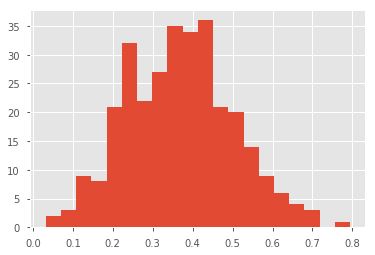

In [39]:
plt.hist(base_learners["random_forest"].predict_proba(X_test)[:, 1][y_test == 1], bins=20);

In [41]:
confusion_matrix(y_test, base_learners["random_forest"].predict(X_test))

array([[1517,   92],
       [ 258,   49]])

In [30]:
for _ in b.columns:
    print(roc_auc_score(y_test, b[_]))

0.6852416071649091
0.7039555594244913
0.666343430580833


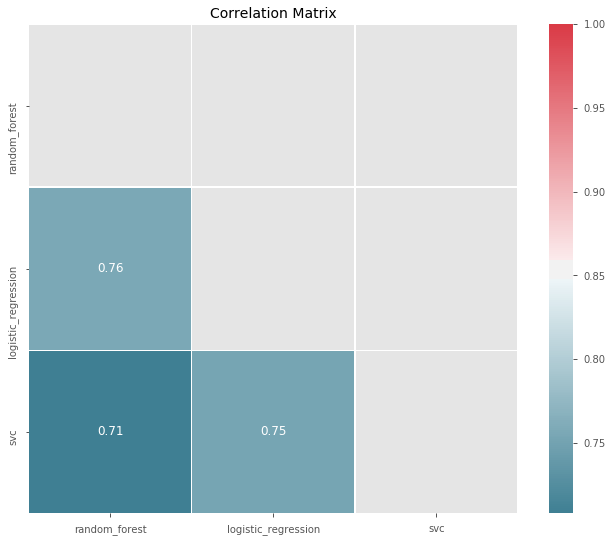

In [144]:
from mlens.visualization import corrmat
corrmat(b.corr(), inflate=False)

In [94]:
from mlens.ensemble import SuperLearner

# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=123,
    verbose=2,
    backend="multiprocessing"
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True) 
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(X_train_u, y_train_u)

# Predict the test set
p_sl = sl.predict_proba(X_test)

print("\nSuper Learner ROC-AUC score: %.3f" % roc_auc_score(y_test, p_sl[:, 1]))


Fitting 2 layers
Processing layer-1             done | 00:16:44
Processing layer-2             done | 00:00:15
Fit complete                        | 00:17:03

Predicting 2 layers
Processing layer-1             done | 00:01:25
Processing layer-2             done | 00:00:02
Predict complete                    | 00:01:50

Super Learner ROC-AUC score: 0.488


In [24]:
xgb_cl = xgb.XGBClassifier(n_jobs=4)
xgb_cl.fit(X_train_d, y_train_d)
roc_auc_score(y_test, xgb_cl.predict(X_test))

0.6351336031241206

In [16]:
# Create DMatrix
DMatrix = xgb.DMatrix(data=X_train_u, label=y_train_u)

# Run cv
params = {"objective": "binary:logistic", "max_depth": 3}
cv_results = xgb.cv(dtrain=DMatrix, params=params, nfold=5, num_boost_round=100, stratified=True, metrics="auc")

In [17]:
cv_results

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.640197,0.009882,0.644413,0.001967
1,0.660559,0.007037,0.667695,0.002831
2,0.664494,0.006079,0.674007,0.002251
3,0.669810,0.005190,0.682914,0.005102
4,0.675974,0.004584,0.690131,0.003859
5,0.680721,0.006498,0.695508,0.003315
6,0.685933,0.007071,0.701589,0.002509
7,0.690604,0.006501,0.708339,0.002703
8,0.694528,0.007776,0.712615,0.001880
9,0.697302,0.008066,0.718544,0.000630


In [ ]:
xgb.sklearn.

 <h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Conclusion</h2><br>